In [1]:
import sys
sys.path.append('~/home/snarduzz/MIP-DeepStroke/UnetCT/')
import os
import numpy as np
import nibabel as nb
import image_augmentation as ia
import image_processing as ip
import create_datasets as cr
import utils
import matplotlib.pyplot as plt
from keras.models import load_model
from metrics import (dice_coefficient, dice_coefficient_loss, dice_coef, dice_coef_loss,
                            weighted_dice_coefficient_loss, weighted_dice_coefficient, tversky_loss, tversky_coeff)

Using TensorFlow backend.


In [2]:
patient_path = "/home/snarduzz/Data/97306792"
stage = "rcoreg_"
dataset_type = "train"
augment = False
mode = "extend"
patch_size = [256,256,32]
returned_dict = cr.load_data_for_patient(patient_path, stage=stage)

In [3]:
def load_old_model(model_file):
    print("Loading pre-trained model")
    custom_objects = {'dice_coefficient_loss': dice_coefficient_loss, 'dice_coefficient': dice_coefficient,
                      'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss,
                      'weighted_dice_coefficient': weighted_dice_coefficient,
                      'weighted_dice_coefficient_loss': weighted_dice_coefficient_loss,
                      'tversky_loss':tversky_loss,
                      'tversky_coeff':tversky_coeff}
    try:
        from keras_contrib.layers import InstanceNormalization
        custom_objects["InstanceNormalization"] = InstanceNormalization
    except ImportError:
        pass
    try:
        return load_model(model_file, custom_objects=custom_objects)
    except ValueError as error:
        if 'InstanceNormalization' in str(error):
            raise ValueError(str(error) + "\n\nPlease install keras-contrib to use InstanceNormalization:\n"
                                          "'pip install git+https://www.github.com/keras-team/keras-contrib.git'")
        else:
            raise error

In [4]:
def predict(images, model, patch_size, verbose=0, batch_size=32):
    if not isinstance(images, list):
        images = [images]  # Transform to 1 dimensional channel

    original_image_size = images[0].shape

    patch_by_channel = []
    for image in images:
        image_norm = ip.preprocess_image(image)
        image_patches = cr.create_patches_from_images(image_norm, patch_size)
        patch_by_channel.append(image_patches)

    # Reshape tensor
    patch_tensor = []
    for p in range(len(patch_by_channel[0])):
        channel_patch = []
        for c in range(len(images)):
            channel_patch.append(patch_by_channel[c][p])
        patch_tensor.append(channel_patch)

    try:
        predictions = model.predict(np.asarray(patch_tensor), batch_size=batch_size, verbose=verbose)[:, 0, :, :, :]
    except: # Not enough memory : switch to mono prediction
        predictions = model.predict(np.asarray(patch_tensor), batch_size=1, verbose=verbose)[:, 0, :, :, :]

    predicted_image = recreate_image_from_patches(original_image_size=original_image_size, list_patches=predictions)
    return predicted_image

In [5]:
modalities = ["TRACE","LESION"]
dict_preprocess = dict()
for modality in modalities:
    if modality!="LESION" and modality!="BACKGROUND":
        image = ip.preprocess_image(returned_dict[modality], preprocessing="standardize")
    else:
        image = ip.preprocess_image(returned_dict[modality], preprocessing="normalize")
    dict_preprocess[modality] = image
    
image_plus = np.zeros([image.shape[0],image.shape[1],image.shape[2]])
image_plus[:image.shape[0],:image.shape[1],:image.shape[2]] = dict_preprocess["TRACE"]

dict_preprocess["TEST"] = image_plus
# create patches, by doing overlap in case of training set
is_train = (dataset_type == 'train')
image_patch = None
dict_patches = dict()
for modality in modalities:
    image_patch = cr.create_patches_from_images(dict_preprocess[modality], patch_size, augment=augment, mode=mode)
    dict_patches[modality] = image_patch

In [6]:
image_patch_rec = cr.create_patches_from_images(dict_preprocess["TEST"], patch_size, augment=True, mode=mode, patch_divider=2)

In [7]:
image_rec = ip.recreate_image_from_patches(dict_preprocess["TEST"].shape, image_patch_rec)

(4, 256, 256, 32)


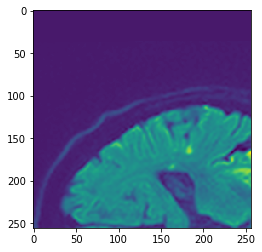

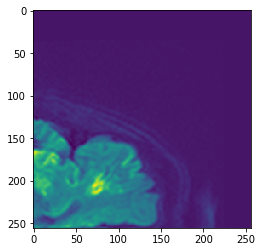

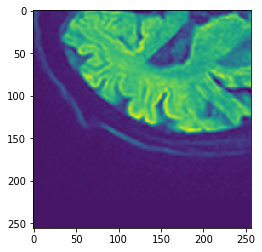

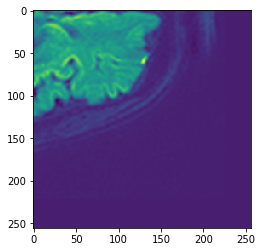

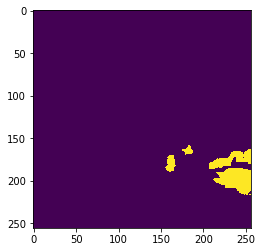

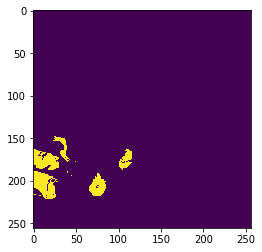

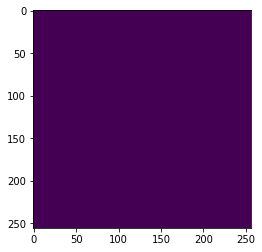

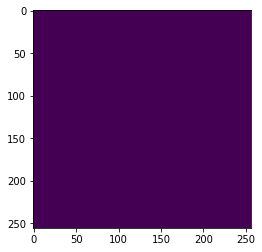

In [8]:
import matplotlib.pyplot as plt
print(np.array(image_patch).shape)
for patch in dict_patches["TRACE"]:
    plt.imshow(patch[:,:, int(patch.shape[2]/2)])
    plt.show()
    
for patch in dict_patches["LESION"]:
    plt.imshow(patch[:,:, int(patch.shape[2]/2)])
    plt.show()

In [11]:
image_rec = ip.recreate_image_from_patches(dict_preprocess["TRACE"].shape, dict_patches["TRACE"])
lesion_rec = ip.recreate_image_from_patches(dict_preprocess["LESION"].shape, dict_patches["LESION"])

In [46]:
from skimage import feature
from scipy.ndimage import gaussian_filter
from skimage.morphology import reconstruction
from skimage import data, segmentation, color
from skimage.future import graph
from skimage import measure
from tqdm import tqdm
from scipy import ndimage, misc

def manual_segment(image, level=200):
    image_c = ip.normalize_numpy(image)
    
    def threshold(img,thr):
        img[img<thr]=0
        img[img>=thr]=1
        return img
    
    def function_slice(img):
        g = ndimage.gaussian_filter(img,sigma=3)
        max_val = np.max(g)
        mean_val = np.mean(g)
        out = threshold(img,max_val-mean_val)
        
        return out
    
    edges = np.zeros(image.shape)
    #for i in tqdm(range(image.shape[2])):
    for i in [14,15,16,17]:
        edges[:,:,i] = function_slice(image[:,:,i])
    return ip.normalize_numpy(np.array(edges))

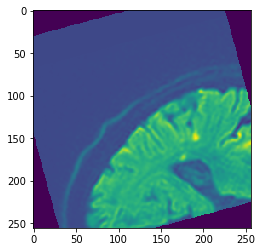

In [61]:
test_img = dict_patches["TRACE"][0]
[test_img],_ = ia.rotate3D([test_img],[],0,,0)
plt.imshow(test_img[:,:,16])
plt.show()